In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using CSV
using DataFrames

PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [2]:
###
#  read in lines to get COF filenames
###
filename = joinpath(pwd(), "./descriptors/cof_names.txt")
cof_name_file = open(filename)
cof_names = readlines(cof_name_file)
close(cof_name_file)

# load properties
chem_props_filename = joinpath(pwd(), "descriptors/chemical_properties.csv")
geo_props_filename  = joinpath(pwd(), "descriptors/geometric_properties.csv")

chemical_properties  = CSV.read(chem_props_filename, DataFrame)
geometric_properties = CSV.read(geo_props_filename, DataFrame)

descriptors = outerjoin(geometric_properties, chemical_properties, on=["crystal_name"]);

In [3]:
###
#  simulation parameters
###
adsorbates = Molecule.(["Kr", "Xe"])
temperature = 298.0 # K
ljff = LJForceField("UFF")
nb_ins_per_vol = 500
nb_cyc_per_vol = 500

# for some reason these ones aren't working.. look into it
skip_for_now = ["07012N3_ddec.cif"]

1-element Vector{String}:
 "07012N3_ddec.cif"

## Calculate Error in Selectivity from Henry Coefficient:
We have the Henry coefficients $ H_{Xe} = h_{Xe} \pm \delta h_{Xe} $, $ H_{Kr} = h_{Kr} \pm \delta h_{Kr}$,  where $h_j$ is the "measured" value and $\delta h_j$ is the associated uncertainty. The Selectivity is calculated as $ S_{Xe/Kr} = s_i \pm \delta s_i$ where $s_i = \frac{h_{Xe}}{h_{Kr}}$. 

To determine the uncertainty of the selectivity $\delta s_i$, we use the fact that the relative errors add in quaderature:
$$ \left(\frac{\delta s_i}{s_i}\right)^2 = \left( \frac{\delta h_{Xe}}{h_{Xe}} \right)^2 + \left( \frac{\delta h_{Kr}}{h_{Kr}} \right)^2  $$

So, 
$$ \delta s_i = s_i\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{\delta h_{Kr}}{h_{Kr}}\right)}^2 } $$

Substituting in the expression for $s_i$, we get:
$$ S_{Xe/Kr} = \frac{h_{Xe}}{h_{Kr}} \pm \frac{h_{Xe}}{h_{Kr}}\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{ \delta h_{Kr}}{h_{Kr}}\right)}^2 }$$

In [4]:
function calculate_henry_selectivity(gas1::Dict{String, Any}, gas2::Dict{String, Any})
    
    h1     = gas1["henry coefficient [mmol/(g-bar)]"]
    h1_err = gas1["err henry coefficient [mmol/(g-bar)]"]
    h2     = gas2["henry coefficient [mmol/(g-bar)]"]
    h2_err = gas2["err henry coefficient [mmol/(g-bar)]"]
    
    sel     =  h1 / h2
    sel_err = sel * sqrt((h1_err / h1)^2 + (h2_err / h2)^2)
    
    return Dict("selectivity" => sel, "err selectivity" => sel_err)
end    

calculate_henry_selectivity (generic function with 1 method)

In [5]:
henry_calculations = Dict{Tuple{String, Symbol}, Dict{String, Any}}()
henry_selectivity  = Dict{Tuple{String, Symbol, Symbol}, Dict{String, Float64}}()
henry_df = DataFrame(crystal_name = String[],
                     H_Xe         = Float64[], # [mmol/(g-bar)]
                     err_H_Xe     = Float64[], # [mmol/(g-bar)]
                     time_Xe      = Float64[], # [min]
                     H_Kr         = Float64[], # [mmol/(g-bar)]
                     err_H_Kr     = Float64[], # [mmol/(g-bar)]
                     time_Kr      = Float64[], # [min]
                     selectivity  = Float64[], 
                     selectivity_err = Float64[]
                    )

for cof_name in cof_names
    xtal = Crystal(cof_name; check_neutrality=false)
    if xtal.name in skip_for_now
        continue
    end
    
    for molecule in adsorbates
        henry_filename = henry_result_savename(xtal, molecule, temperature, ljff, nb_ins_per_vol)
        @load joinpath(PorousMaterials.rc[:paths][:simulations], henry_filename) results
        henry_calculations[(xtal.name, molecule.species)] = results
    end
    
    # Unfortunately, I've hard coded this for the time being. will fix later
    d1 = henry_calculations[(xtal.name, :Xe)]
    d2 = henry_calculations[(xtal.name, :Kr)]
    henry_selectivity[(xtal.name, :Xe, :Kr)] = calculate_henry_selectivity(d1, d2)  
    
    tmp_dict = Dict("crystal_name"  => xtal.name,
                     "H_Xe"         => henry_calculations[(xtal.name, :Xe)]["henry coefficient [mmol/(g-bar)]"],
                     "err_H_Xe"     => henry_calculations[(xtal.name, :Xe)]["err henry coefficient [mmol/(g-bar)]"],
                     "time_Xe"      => henry_calculations[(xtal.name, :Xe)]["elapsed time (min)"],
                     "H_Kr"         => henry_calculations[(xtal.name, :Kr)]["henry coefficient [mmol/(g-bar)]"],
                     "err_H_Kr"     => henry_calculations[(xtal.name, :Kr)]["err henry coefficient [mmol/(g-bar)]"],
                     "time_Kr"      => henry_calculations[(xtal.name, :Kr)]["elapsed time (min)"],
                     "selectivity"  => henry_selectivity[(xtal.name, :Xe, :Kr)]["selectivity"], 
                     "selectivity_err" => henry_selectivity[(xtal.name, :Xe, :Kr)]["err selectivity"]
                    )
    row = [tmp_dict[key] for key in names(henry_df)]
    push!(henry_df, row)
end

CSV.write(joinpath(pwd(), "henry_calculations.csv"), henry_df)
henry_df[1:5, :]

In [22]:
length(henry_df[:, "crystal_name"])

611

In [21]:
length(descriptors[:, "crystal_name"])

612

## Plotting Functions

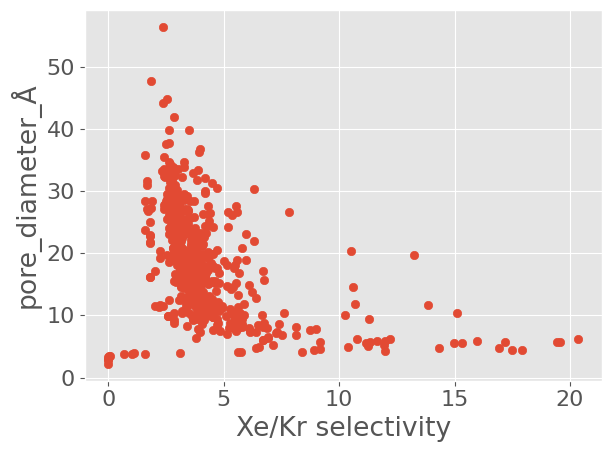

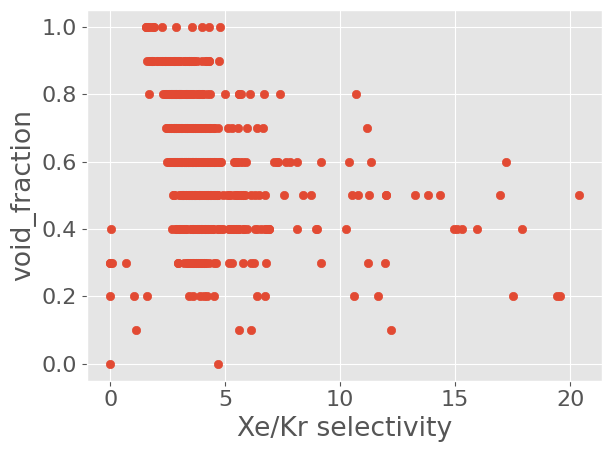

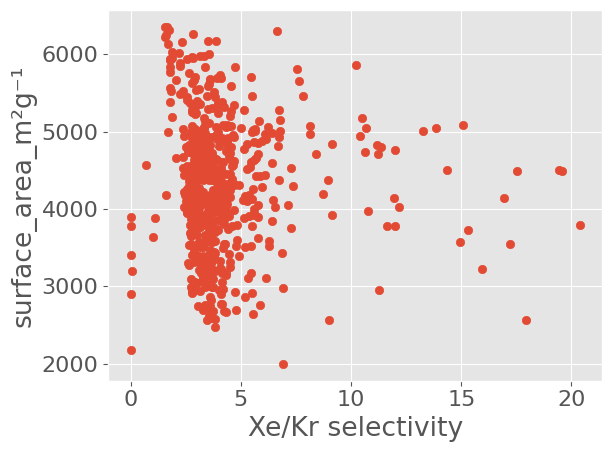

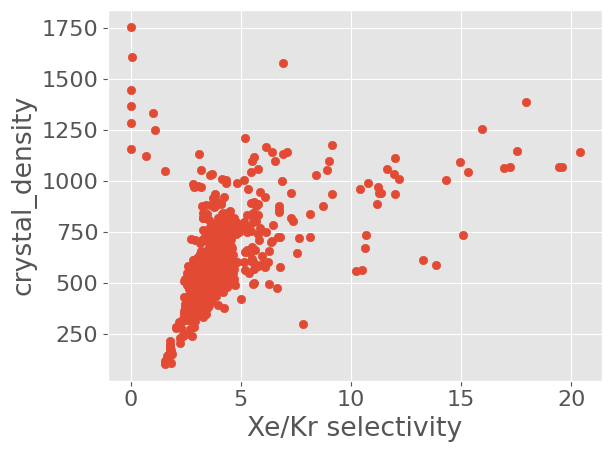

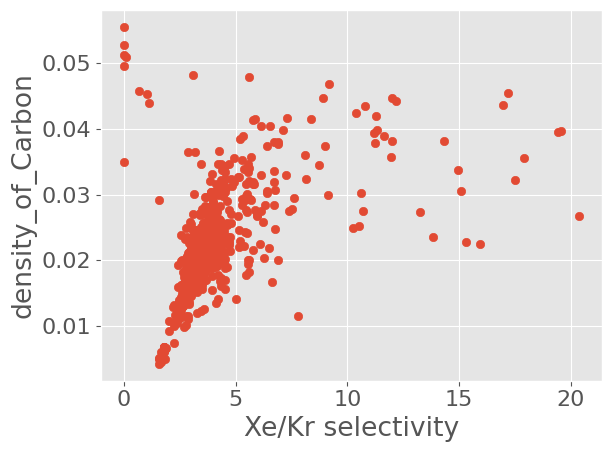

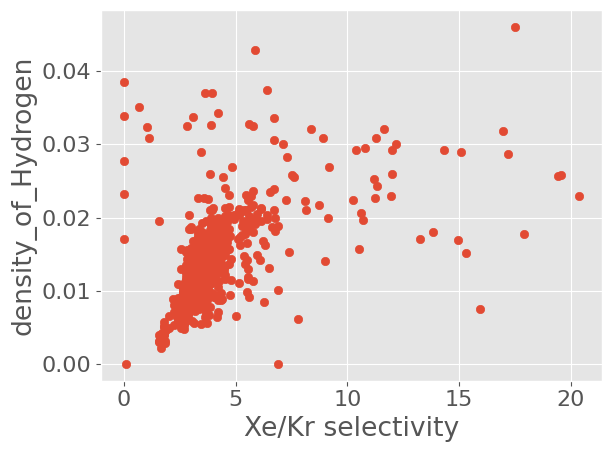

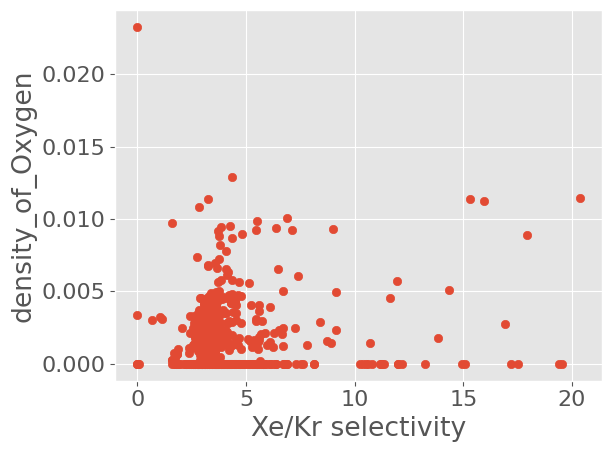

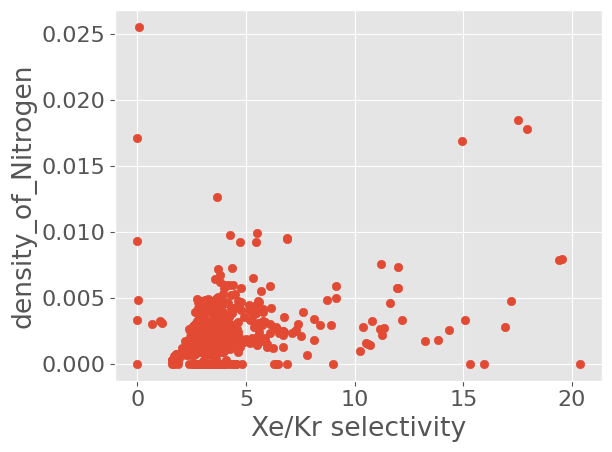

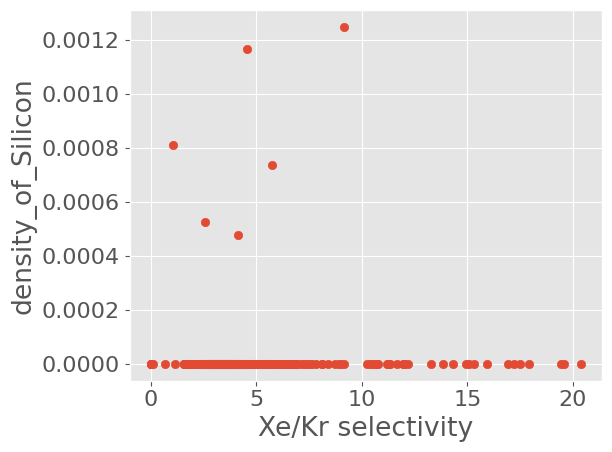

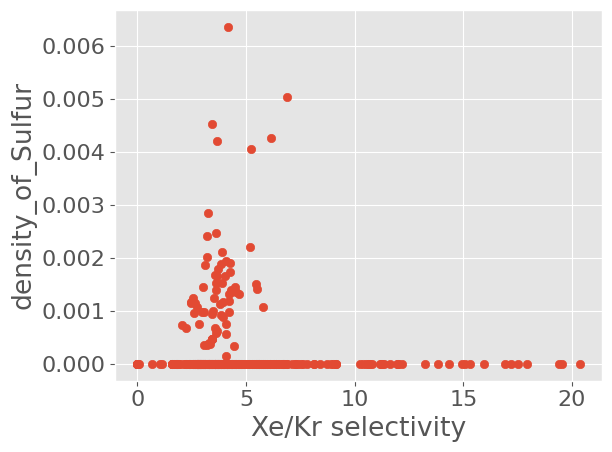

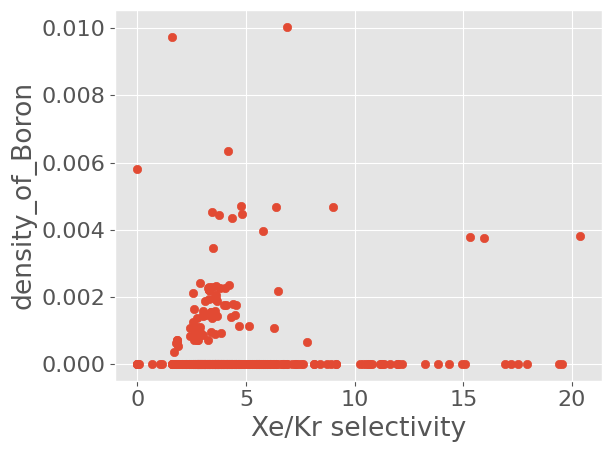

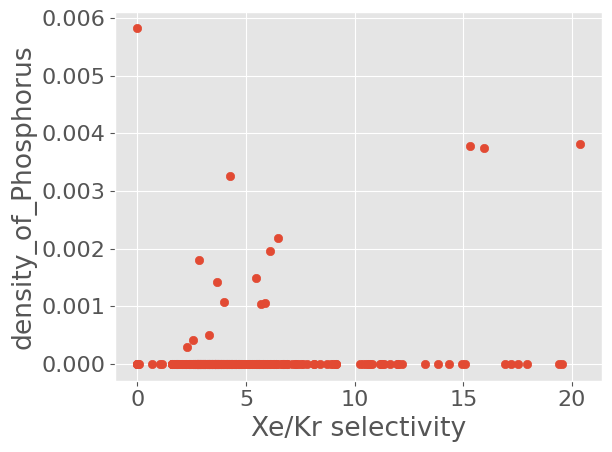

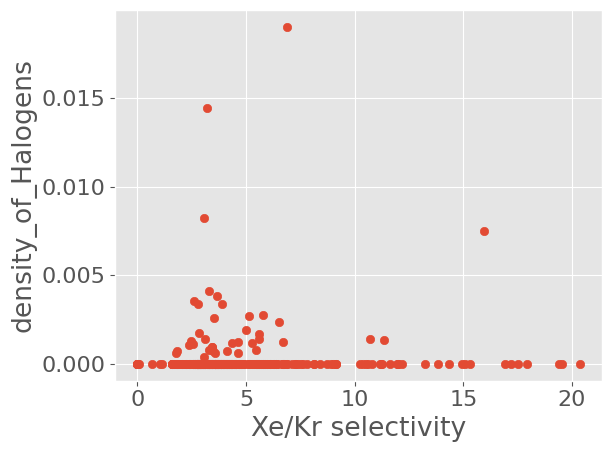

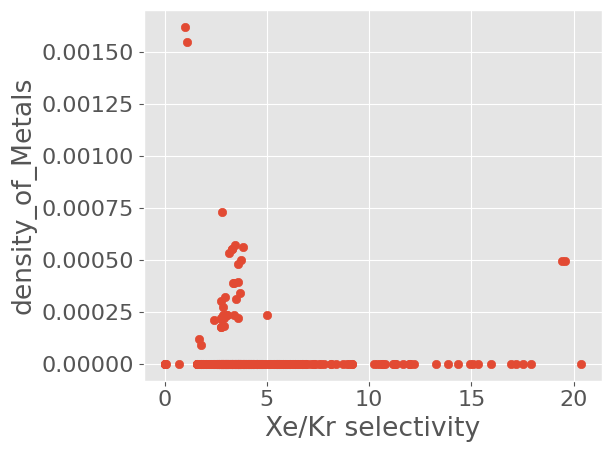

In [27]:
for name in names(descriptors)
    if name == "crystal_name"
        continue
    end
    
    figure()
    x = 
    y = descriptors[:, name]
    scatter(henry_df[:, "selectivity"], descriptors[:, name])
    
    xlabel("Xe/Kr selectivity")
    ylabel(name)
    tight_layout()
end